In [1]:
import numpy as np
import lqrpols
import matplotlib.pyplot as plt

### System definition

Construct a simple linear system: `x(t+1) = A x (t) + B u(t) + w(t)`
and a simple quadratic cost: `J(x,u) = Σ (x' Q x + u' R u)`

In [2]:
np.random.seed(1337)

# Define matrices:
A = np.array([[1,1], [0,1]])
B = np.array([[0], [1]])
n, m = B.shape
Q = np.array([[1,0], [0,0]])
R = np.array([[1.0]])
# initial condition
x0 = np.vstack((-1,0))
# number of time steps to simulate
N = 10
# Gaussian noise std
w_std = 1e-2

### Classic good, old, model-based LQR

First we use model-based control techniques to solve the LQR problem. We perform system identification to estimate matrices `A` and `B`

In [3]:
# Single rollout, N steps
A_est, B_est = lqrpols.lsqr_estimator(A, B, x0, w_std, 1, N)
print("True matrices: \nA = {}, \nB = {}.".format(A, B))
print("Estimated matrices: \nA_est = {}, \nB_est = {}.".format(A_est, B_est))

True matrices: 
A = [[1 1]
 [0 1]], 
B = [[0]
 [1]].
Estimated matrices: 
A_est = [[1.00032885e+00 9.99484822e-01]
 [2.11465750e-04 9.99153277e-01]], 
B_est = [[-0.00174996]
 [ 0.99998723]].


/Users/tzanis/Documents/GitHub/rl-playground/fundamentals/lqr/lqrpols.py:129: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  tmp = np.linalg.lstsq(


Now minimize the cost using the classic results for LQR.

In [4]:
# True model results:
# Cost for finite time horizon, true model
J_finite_opt = lqrpols.cost_finite_model(A, B, Q, R, x0, N, A, B)
# Gain of optimal infinite time horizon LQR controller
K_opt = -lqrpols.lqr_gain(A, B, Q, R)
# Optimal cost for infinite time horizon
J_inf_opt = lqrpols.cost_inf_K(A, B, Q, R, K_opt) 

# Estimated model results (controller knows (A_est,B_est), but executed on (A,B))
# Finite time horizon, one rollout
J_one_rollout = lqrpols.cost_finite_model(A, B, Q, R, x0, N, A_est, B_est)
K_est = -lqrpols.lqr_gain(A_est, B_est, Q, R)
# Infinite horizon using the gain K_est from estimated model
J_one_rollout_inf = lqrpols.cost_inf_K(A, B, Q, R, K_est)

# Print how much the one rolout differs from optimal
print("Finite time horizon: |J* - J_one_rollout| = {}.".format(abs(J_one_rollout-J_finite_opt)))
print("Infinite time horizon: |J* - J_one_rollout| = {}.".format(abs(J_one_rollout_inf-J_inf_opt)))

Finite time horizon: |J* - J_one_rollout| = 3.554685845230665e-06.
Infinite time horizon: |J* - J_one_rollout| = 6.226094496852852e-06.


### Compare with model-free RL methods

Compare the model-based LQR results with model-free RL methods: policy gradient, random search, uniform random sampling.

#### Simulations

In [5]:
# N_vals = np.floor(np.linspace(1,75,num=7)).astype(int)
N_vals = [1, 2, 5, 7, 12, 25, 50, 75, 100, 125]
N_trials = 10

# Cost matrices: [trials x N_vals]
# Classic control
J_finite_est = np.zeros((N_trials,len(N_vals)))
J_finite_estK = np.zeros((N_trials,len(N_vals)))
J_inf_est = np.zeros((N_trials,len(N_vals)))
# Random search
J_finite_rs = np.zeros((N_trials,len(N_vals)))
J_inf_rs = np.zeros((N_trials,len(N_vals)))
# Policy gradient
J_finite_pg = np.zeros((N_trials,len(N_vals)))
J_inf_pg = np.zeros((N_trials,len(N_vals)))
# Uniform random sampling
J_finite_ur = np.zeros((N_trials,len(N_vals)))
J_inf_ur = np.zeros((N_trials,len(N_vals)))

# Cost for zero control
baseline = lqrpols.cost_finite_K(A, B, Q, R, x0, N, np.zeros((m,n)))


# For each 
for T in range(len(N_vals)):
    # For trial 1 through N_trials
    for trial in range(N_trials):
        # 1. Classic control
        # Estimate model: use N x 40 to match sample budget of policy gradient
        A_est,B_est = lqrpols.lsqr_estimator(A, B, x0, w_std, N_vals[T] * 40, N)
        # Finite time horizon cost with estimated model
        J_finite_est[trial, T] = lqrpols.cost_finite_model(A, B, Q, R, x0, N, A_est, B_est)
        # Infinite time horizon LQR controller based on estimated model
        K_est = -lqrpols.lqr_gain(A_est, B_est, Q, R)
        # Cost of using the infinite time horizon solution for finite time horizon
        J_finite_estK[trial, T] = lqrpols.cost_finite_K(A, B, Q, R, x0, N, K_est)
        # Infinite time horizon cost using K_est
        J_inf_est[trial, T] = lqrpols.cost_inf_K(A, B, Q, R, K_est)

        # 2. Policy gradient, batchsize 40 per iteration
        # K_pg = lqrpols.policy_gradient_linear_policy(A, B, Q, R, x0, w_std, N_vals[T], N)
        # Adam performs better than stochastic gradient descent:
        K_pg = lqrpols.policy_gradient_adam_linear_policy(A, B, Q, R, x0, w_std, N_vals[T], N)
        J_finite_pg[trial, T] = lqrpols.cost_finite_K(A, B, Q, R, x0, N, K_pg)
        J_inf_pg[trial, T] = lqrpols.cost_inf_K(A, B, Q, R, K_pg)
        
        # random search, batchsize 4, so uses 8 rollouts per iteration
        K_rs = lqrpols.random_search_linear_policy(A, B, Q, R, x0, w_std, N_vals[T] * 5, N)
        J_finite_rs[trial, T] = lqrpols.cost_finite_K(A, B, Q, R, x0, N, K_rs)
        J_inf_rs[trial, T] = lqrpols.cost_inf_K(A, B, Q, R, K_rs)

        # uniformly random sampling, N x 40 to match sample budget of policy gradient
        K_ur = lqrpols.uniform_random_linear_policy(A, B, Q, R, x0, w_std, N_vals[T] * 40, N)
        J_finite_ur[trial, T] = lqrpols.cost_finite_K(A, B, Q, R, x0, N, K_ur)
        J_inf_ur[trial, T] = lqrpols.cost_inf_K(A, B, Q, R, K_ur)

#### Plotting

Now we plot the resulting cost of the RL approaches against the control-theoretic one. As we seen above the difference between the optimal cost of the true model and the one using the controller from the estimated model is extremely small. So we plot only the optimal cost here. 

##### Finite-horizon

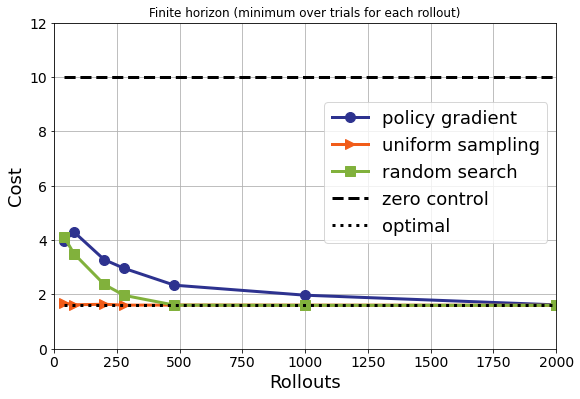

In [6]:
# Plot parameters
colors = [ '#2D328F', '#F15C19',"#81b13c","#ca49ac"]
label_fontsize = 18
tick_fontsize = 14
linewidth = 3
markersize = 10

tot_samples = 40 * np.array(N_vals)

# Plot costs
plt.plot(tot_samples, np.amin(J_finite_pg,axis=0), 'o-', color=colors[0], linewidth=linewidth, markersize=markersize, label='policy gradient')
plt.plot(tot_samples, np.amin(J_finite_ur,axis=0), '>-', color=colors[1], linewidth=linewidth, markersize=markersize, label='uniform sampling')
plt.plot(tot_samples, np.amin(J_finite_rs,axis=0), 's-', color=colors[2], linewidth=linewidth, markersize=markersize, label='random search')
plt.plot([tot_samples[0], tot_samples[-1]], [baseline, baseline], color='#000000', linewidth=linewidth, linestyle='--', label='zero control')
plt.plot([tot_samples[0], tot_samples[-1]], [J_finite_opt, J_finite_opt], color='#000000', linewidth=linewidth, linestyle=':', label='optimal')

plt.axis([0,2000,0,12])
plt.title('Finite horizon (minimum over trials for each rollout)')
plt.xlabel('Rollouts',fontsize=label_fontsize)
plt.ylabel('Cost',fontsize=label_fontsize)
plt.legend(fontsize=18, bbox_to_anchor=(1.0, 0.54))
plt.xticks(fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
plt.grid(True)

fig = plt.gcf()
fig.set_size_inches(9, 6)

plt.show()

After about 500 rollouts (500 trials of length 10), all of the methods seem equally good. Though, again, this is comparing to one rollout of classic control. 

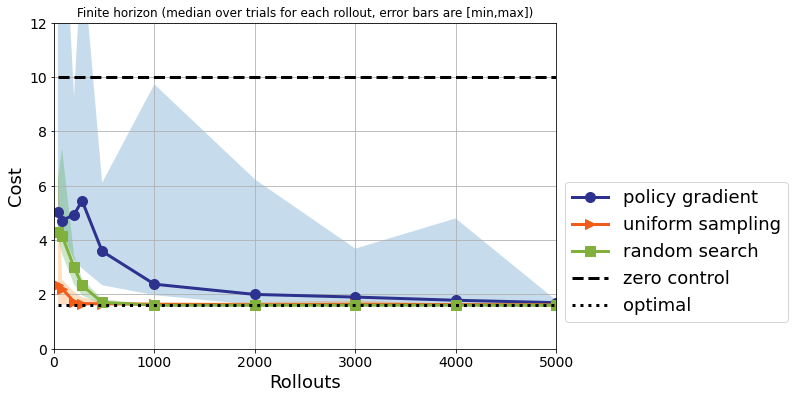

In [7]:
plt.plot(tot_samples, np.median(J_finite_pg,axis=0), 'o-',color=colors[0], linewidth=linewidth, markersize=markersize, label='policy gradient')
plt.fill_between(tot_samples, np.amin(J_finite_pg,axis=0), np.amax(J_finite_pg,axis=0), alpha=0.25)

plt.plot(tot_samples, np.median(J_finite_ur,axis=0), '>-', color=colors[1], linewidth=linewidth, markersize=markersize, label='uniform sampling')
plt.fill_between(tot_samples, np.amin(J_finite_ur,axis=0), np.amax(J_finite_ur,axis=0), alpha=0.25)

plt.plot(tot_samples, np.median(J_finite_rs,axis=0), 's-', color=colors[2], linewidth=linewidth, markersize=markersize, label='random search')
plt.fill_between(tot_samples, np.amin(J_finite_rs,axis=0), np.amax(J_finite_rs,axis=0), alpha=0.25)


plt.plot([tot_samples[0], tot_samples[-1]], [baseline, baseline], color='#000000', linewidth=linewidth, linestyle='--', label='zero control')
plt.plot([tot_samples[0], tot_samples[-1]], [J_finite_opt, J_finite_opt], color='#000000', linewidth=linewidth, linestyle=':', label='optimal')

plt.axis([0,5000,0,12])
plt.title('Finite horizon (median over trials for each rollout, error bars are [min,max])')
plt.xlabel('Rollouts',fontsize=label_fontsize)
plt.ylabel('Cost',fontsize=label_fontsize)
plt.legend(fontsize=18, bbox_to_anchor=(1.0, 0.54))
plt.xticks(fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
plt.grid(True)

fig = plt.gcf()
fig.set_size_inches(9, 6)

plt.show()

##### Meta learning: generalization to infinite-time horizon?

Good RL policies learned should be able to generalize. Here we take the RL controllers learned on the finite-time horizons and see the performance on arbitrarily long horizons. Will the policies still achieve high performance?

For LQR control we can plug in our point estimate and solve a Ricatti equation to produce a controller for an infinite-time horizon. With model-free methods, we have a fixed controller, and it is exactly this that we use for the infinite-time horizon. 

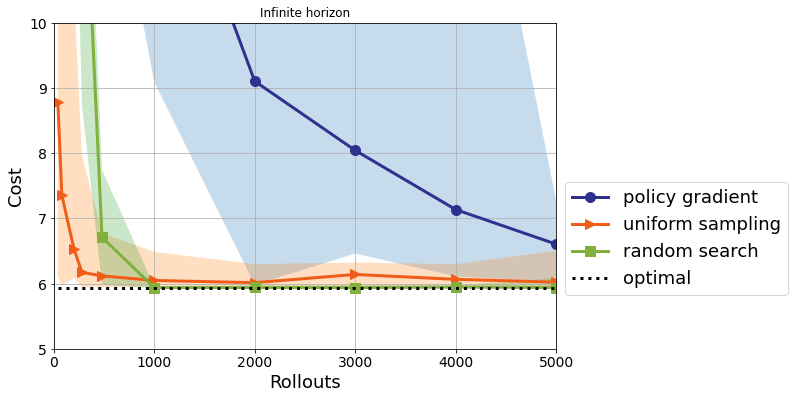

In [8]:
plt.plot(tot_samples, np.median(J_inf_pg,axis=0), 'o-', color=colors[0], linewidth=linewidth, markersize=markersize, label='policy gradient')
plt.fill_between(tot_samples, np.amin(J_inf_pg,axis=0), np.minimum(np.amax(J_inf_pg,axis=0),15), alpha=0.25)


plt.plot(tot_samples, np.median(J_inf_ur,axis=0), '>-', color=colors[1], linewidth=linewidth, markersize=markersize, label='uniform sampling')
plt.fill_between(tot_samples, np.amin(J_inf_ur,axis=0), np.minimum(np.amax(J_inf_ur,axis=0),15), alpha=0.25)

plt.plot(tot_samples, np.median(J_inf_rs,axis=0), 's-', color=colors[2], linewidth=linewidth, markersize=markersize, label='random search')
plt.fill_between(tot_samples, np.amin(J_inf_rs,axis=0), np.minimum(np.amax(J_inf_rs,axis=0),15), alpha=0.25)

plt.plot([tot_samples[0], tot_samples[-1]], [J_inf_opt, J_inf_opt], color='#000000', linewidth=linewidth, linestyle=':', label='optimal')

plt.axis([0,5000,5,10])
plt.title('Infinite horizon')
plt.xlabel('Rollouts',fontsize=label_fontsize)
plt.ylabel('Cost',fontsize=label_fontsize)
plt.legend(fontsize=18, bbox_to_anchor=(1.0, 0.54))
plt.xticks(fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
plt.grid(True)

fig = plt.gcf()
fig.set_size_inches(9, 6)

plt.show()

What we observe above for the policy gradient is that the resulting controller is **not stabilizing**, which is essential for infinite-time horizon trajectories to not blow up! Below we plot how requently the various search methods find stabilizing control policies when looking at a finite horizon. 

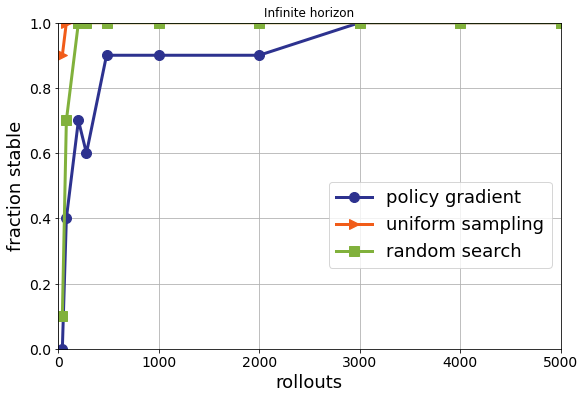

In [9]:
plt.plot(tot_samples, 1-np.sum(np.isinf(J_inf_pg), axis=0)/10, 'o-', color=colors[0], linewidth=linewidth, markersize=markersize, label='policy gradient')
plt.plot(tot_samples, 1-np.sum(np.isinf(J_inf_ur), axis=0)/10, '>-', color=colors[1], linewidth=linewidth, markersize=markersize, label='uniform sampling')
plt.plot(tot_samples, 1-np.sum(np.isinf(J_inf_rs), axis=0)/10, 's-', color=colors[2], linewidth=linewidth, markersize=markersize, label='random search')

plt.axis([0,5000,0,1])
plt.title('Infinite horizon')
plt.xlabel('rollouts',fontsize=label_fontsize)
plt.ylabel('fraction stable',fontsize=label_fontsize)
plt.legend(fontsize=18, bbox_to_anchor=(1.0, 0.54))
plt.xticks(fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
plt.grid(True)

fig = plt.gcf()
fig.set_size_inches(9, 6)

plt.show()